In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)
missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = df[columns_to_keep]
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])


In [7]:
# Label encode all categorical columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

X = skin_cancer_df.drop('target', axis=1).drop('copyright_license', axis=1)
y = skin_cancer_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [8]:

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf.fit(X_train_sm, y_train_sm)

accuracy = rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

y_pred = rf.predict(X_test) 
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

Top 10 Most Important Features:
                         feature  importance
43                     iddx_full    0.352184
44                        iddx_1    0.327454
14                      tbp_lv_H    0.056242
45  tbp_lv_dnn_lesion_confidence    0.038268
18                tbp_lv_areaMM2    0.029986
5         clin_size_long_diam_mm    0.025785
29            tbp_lv_minorAxisMM    0.022449
33            tbp_lv_perimeterMM    0.021065
22                 tbp_lv_deltaB    0.019722
15                   tbp_lv_Hext    0.016412

Confusion Matrix:
[[80138     0]
 [    0    74]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80138
           1       1.00      1.00      1.00        74

    accuracy                           1.00     80212
   macro avg       1.00      1.00      1.00     80212
weighted avg       1.00      1.00      1.00     80212



### Top 10 Most Important Features Graph

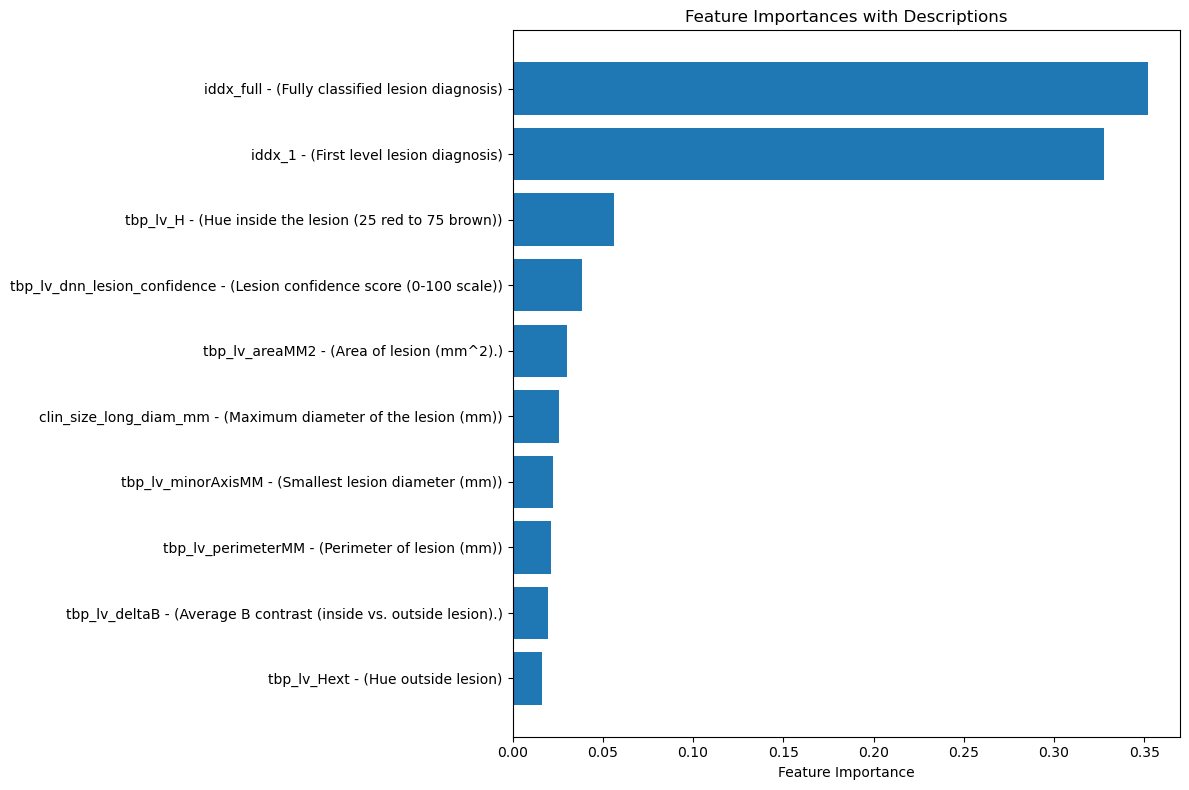

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Mapping of Feature Names to Descriptions
feature_descriptions = {
    "isic_id": "Unique case identifier",
    "patient_id": "Unique patient identifier",
    "age_approx": "Age of the Patient",
    "sex": "Sex of the person",
    "anatom_site_general": "Location of the lesion",
    "clin_size_long_diam_mm": "Maximum diameter of the lesion (mm)",
    "image_type": "Image type",
    "tbp_tile_type": "Lighting modality of the 3D TBP source image.",
    "tbp_lv_A": "A inside lesion",
    "tbp_lv_Aext": "A outside lesion",
    "tbp_lv_B": "B inside lesion",
    "tbp_lv_Bext": "B outside lesion",
    "tbp_lv_C": "Chroma inside lesion",
    "tbp_lv_Cext": "Chroma outside lesion",
    "tbp_lv_H": "Hue inside the lesion (25 red to 75 brown)",
    "tbp_lv_Hext": "Hue outside lesion",
    "tbp_lv_L": "L inside lesion",
    "tbp_lv_Lext": "L outside lesion.",
    "tbp_lv_areaMM2": "Area of lesion (mm^2).",
    "tbp_lv_area_perim_ratio": "Border jaggedness, the ratio between lesions perimeter and area",
    "tbp_lv_color_std_mean": "Color irregularity",
    "tbp_lv_deltaA": "Average A contrast (inside vs. outside lesion).",
    "tbp_lv_deltaB": "Average B contrast (inside vs. outside lesion).",
    "tbp_lv_deltaL": "Average L contrast (inside vs. outside lesion).",
    "tbp_lv_deltaLBnorm": "Contrast between the lesion and its immediate surrounding skin",
    "tbp_lv_eccentricity": "Eccentricity.",
    "tbp_lv_location": "Classification of anatomical location.",
    "tbp_lv_location_simple": "Classification of anatomical location, simple.",
    "tbp_lv_minorAxisMM": "Smallest lesion diameter (mm)",
    "tbp_lv_nevi_confidence": "Nevus confidence score (0-100 scale)",
    "tbp_lv_norm_border": "Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.",
    "tbp_lv_norm_color": "Color variation (0-10 scale)",
    "tbp_lv_perimeterMM": "Perimeter of lesion (mm)",
    "tbp_lv_radial_color_std_max": "Color asymmetry",
    "tbp_lv_stdL": "Standard deviation of L inside lesion.",
    "tbp_lv_stdLExt": "Standard deviation of L outside lesion.",
    "tbp_lv_symm_2axis": "Border asymmetry",
    "tbp_lv_symm_2axis_angle": "Lesion border asymmetry angle.",
    "tbp_lv_x": "X-coordinate of the lesion on 3D TBP.",
    "tbp_lv_y": "Y-coordinate of the lesion on 3D TBP.",
    "tbp_lv_z": "Z-coordinate of the lesion on 3D TBP.",
    "attribution": "Image attribution, synonymous with image source.",
    "copyright_license": "Copyright license.",
    "target": "Binary class {0: benign, 1: malignant}.",
    "lesion_id": "Unique lesion identifier",
    "iddx_full": "Fully classified lesion diagnosis",
    "iddx_1": "First level lesion diagnosis",
    "iddx_2": "Second level lesion diagnosis",
    "iddx_3": "Third level lesion diagnosis",
    "iddx_4": "Fourth level lesion diagnosis",
    "iddx_5": "Fifth level lesion diagnosis",
    "mel_mitotic_index": "Mitotic index of invasive malignant melanomas",
    "mel_thick_mm": "Thickness in depth of melanoma invasion",
    "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100 scale)"
}


top_10 = feature_importance.head(10).iloc[::-1]

graph_data = {}

for index in top_10.index:
    feature = top_10.loc[index, 'feature']
    importance = top_10.loc[index, 'importance']
    graph_data[f"{top_10.loc[index, 'feature']} - ({feature_descriptions[feature]})"] = importance

    
descriptions = list(graph_data.keys())
importances = list(graph_data.values())

# Set the figure size
plt.figure(figsize=(12, 8))

plt.barh(descriptions, importances)

# Add labels and title
plt.xlabel("Feature Importance")
plt.title("Feature Importances with Descriptions")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### ROC Curve

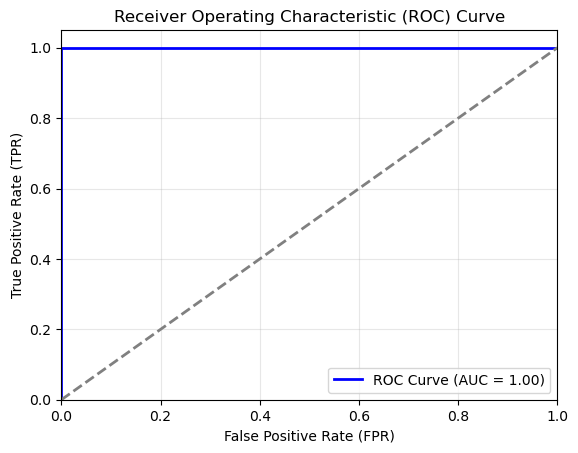

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

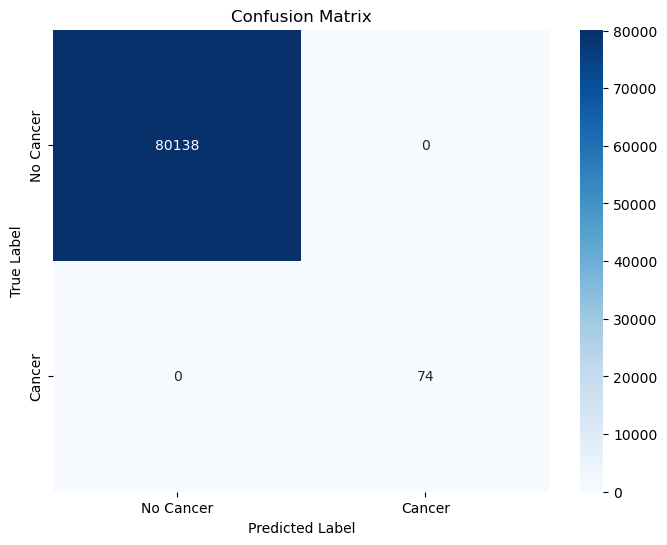

In [11]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()